In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/transformer"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_315358/4288604765.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Device: cuda:0


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3,2
pl.seed_everything(42)
q = torch.randn(seq_len,d_k)
k = torch.randn(seq_len,d_k)
v = torch.randn(seq_len,d_k)
values, attention = scaled_dot_product(q,k,v)
print('Q\n',q)
print('K\n',k)
print('V\n',v)
print('Values\n',values)
print('Attention\n',attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


In [41]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        print('qkv_proj_weights',self.qkv_proj.weight.size())
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        print('x.size',x.size())
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        #print(qkv.size())
        q, k, v = qkv.chunk(3, dim=-1)
        #print(k.size())
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [6]:
batch_size = 2
seq_length = 4
embed_dim = 8
x = torch.randn(batch_size,seq_length,embed_dim)
multihead = MultiheadAttention(embed_dim,embed_dim,2)
multihead(x)

torch.Size([2, 2, 4, 12])
torch.Size([2, 2, 4, 4])


tensor([[[-0.0403, -0.2677,  0.0437,  0.0506, -0.2715,  0.4273, -0.1843,
           0.3820],
         [ 0.0800, -0.3428,  0.1153,  0.2709, -0.4976,  0.4218, -0.2071,
           0.4273],
         [-0.0732, -0.2646,  0.0074,  0.0559, -0.3490,  0.5160, -0.2839,
           0.5614],
         [-0.0955, -0.3103, -0.0302,  0.0311, -0.2589,  0.5526, -0.2141,
           0.5695]],

        [[ 0.5411,  0.4086,  0.6636,  0.0396, -0.2651, -0.2291,  0.0701,
          -0.5695],
         [ 0.6052,  0.4054,  0.6563,  0.0260, -0.2637, -0.1370,  0.0658,
          -0.4737],
         [ 0.3929,  0.5683,  0.7120, -0.0327, -0.0755, -0.3644,  0.2092,
          -0.5926],
         [ 0.5733,  0.3389,  0.7052, -0.1171, -0.2666, -0.1914, -0.1086,
          -0.6962]]], grad_fn=<ViewBackward0>)

In [7]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [8]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [10]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [34]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [12]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [13]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [14]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 6, 1, 2, 0, 9, 2, 6, 7, 4, 6, 2, 1, 1])
Labels:     tensor([1, 1, 2, 6, 4, 7, 6, 2, 9, 0, 2, 1, 6, 2, 6, 9])


In [38]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [39]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=10,
                         gradient_clip_val=5,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask2.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [42]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

/home/home/zeenat_supro/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 8.5 K 
3 | output_net          

self.hparams.input_dim 10
 self.hparams.model_dim 32
qkv_proj_weights torch.Size([96, 32])


Sanity Checking: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])


/home/home/zeenat_supro/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/home/zeenat_supro/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

Validation: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([104, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

Validation: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([104, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

Validation: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([104, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

/home/home/zeenat_supro/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])


/home/home/zeenat_supro/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([104, 16, 32])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size torch.Size([128, 16, 32])
x.size tor

In [19]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [35]:
data_input, labels = next(iter(val_loader))
#print('Data shape',data_input.size())
#print('Data Input',data_input)
#print('Label shape',labels.size())
#print('Label',labels)
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
#print('One hot vector input data size',inp_data.size())
#print('Sample',data_input[1])
#print('Sample input',inp_data[1])
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

Data shape torch.Size([128, 16])
Label shape torch.Size([128, 16])
One hot vector input data size torch.Size([128, 16, 10])
torch.Size([128, 1, 16, 96])
torch.Size([128, 1, 16, 32])
torch.Size([128, 1, 16, 96])
torch.Size([128, 1, 16, 32])


In [21]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [22]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

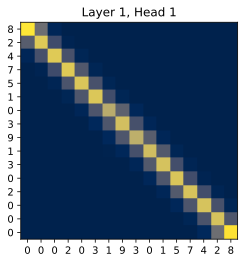

In [23]:
plot_attention_maps(data_input, attention_maps, idx=0)